## Notes on entire dataset

Looks like `historical_transactions.csv` and `new_merchant_transactions.csv` have identical columns.  Some people have suggested just merging them.

`category_1`, `category_2`, `city_id`, and `state_id` are in both `{historical,new_merchant}_transactions.csv` AND in `merchants.csv`.  Will have to see if those are values of the merchants in both, or if they are properties of the merchants in `merchants.csv` and different properties of the transactions in `*transactions.csv`.  For example, is the `state_id` in `merchants.csv` where the merchant's headquarters is, while `state_id` in `*transactions.csv` means the state where the transaction occurred?  Or does it always mean the merchant's state?

However, `category_3` is only in `*transactions.csv`, while `category_4` is only in `merchants.csv`.  So presumably `category_3` is a property of each transaction, while `category_4` is a property of each merchant.

Also, `merchant_category_id`, `subsector_id` are in both `*transactions.csv` AND in `merchants.csv`.  Presumaby they have the same value, but should double-check that!  What I mean is, for any entry in `*transactions.csv`, if you look up that `merchant_id` in `merchants.csv`, the `merchant_category_id` there should match the one for your entry in `*transactions.csv`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

## Data Loading

In [2]:
# Datatypes of each column
dtypes = {
    'authorized_flag':      'str',     # Y or N
    'card_id':              'str',     # 325540 unique values
    'city_id':              'int16',   # -1 then 1 to 347 (is -1 supposed to be nan?)
    'category_1':           'str',     # Y or N
    'installments':         'int8',    # -25, then -1 thru 12 (-1 supposed to be nan?)
    'category_3':           'str',     # A, B, C, and nan
    'merchant_category_id': 'int16',   # 2 to 891
    'merchant_id':          'str',     # lots of unique ones here and nans
    'month_lag':            'int8',    # -13 thru 0
    'purchase_amount':      'float32', # min: -0.746, med: -0.699, max: 11269.667
    'purchase_date':        'str',     # YYYY-MM-DD hh:mm:ss
    'category_2':           'float32', # 1 thru 5 and nan
    'state_id':             'int8',    # -1 then 1 thru 24
    'subsector_id':         'int8'     # 1 thru 41
}

# Load the data
hist_trans = pd.read_csv('../input/historical_transactions.csv', 
                         usecols=dtypes.keys(),
                         dtype=dtypes)

# Convert time column
hist_trans['purchase_date'] = hist_trans['purchase_date'].str.slice(0, 19)
hist_trans['purchase_date'] = pd.to_datetime(hist_trans['purchase_date'],
                                             utc=True,
                                             format='%Y-%m-%d %H:%M:%S')

In [3]:
hist_trans.sample(10)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
24691243,Y,C_ID_6e5bf69f03,116,N,0,A,437,M_ID_b2dcfc9c2a,-2,-0.739395,2017-12-20 14:02:23+00:00,1.0,9,15
1037359,Y,C_ID_febc1f8fed,17,N,1,B,842,M_ID_1b9c181f33,0,-0.553922,2018-02-12 21:19:15+00:00,4.0,22,37
14374133,Y,C_ID_1988bcbc37,333,N,1,B,307,M_ID_7e430a30bb,-12,-0.671790,2017-02-15 20:58:34+00:00,1.0,9,19
13423999,Y,C_ID_784ef509e7,300,N,2,C,2,M_ID_a1e5f5939d,0,-0.671790,2018-02-19 12:48:46+00:00,1.0,15,20
4464331,Y,C_ID_a8178f67c3,320,N,1,B,506,M_ID_e2d7c10969,-5,-0.728876,2017-09-22 17:59:51+00:00,4.0,13,30
15112388,Y,C_ID_5bcab6185a,19,N,0,A,367,M_ID_0862bd288b,-1,-0.693263,2017-11-23 00:00:00+00:00,1.0,9,16
20068318,Y,C_ID_976b210deb,-1,Y,1,B,879,M_ID_9139332ccc,-9,-0.734902,2017-05-26 06:13:35+00:00,NaN,-1,29
8705723,Y,C_ID_b614f7f267,69,N,0,A,68,M_ID_371eb8c796,-4,-0.716870,2017-10-06 19:53:22+00:00,1.0,9,27
3479599,Y,C_ID_f0cbdcc01d,69,N,1,B,879,M_ID_00a6ca8a8a,-3,-0.717606,2017-11-10 22:39:47+00:00,1.0,9,29
771007,Y,C_ID_a8587a88c1,276,N,0,A,68,M_ID_2854feb770,-7,-0.665855,2017-04-15 12:30:50+00:00,1.0,9,27


## EDA

Only `category_3`, `merchant_id`, and `category_2` have any `NaN` values.

In [4]:
# Print info about each col
info_df = pd.DataFrame(index=hist_trans.keys(),
                       columns=['Dtype', 'Nulls', 'Info'])
for name, col in hist_trans.items():
    t_null = col.isnull().sum()
    t_dtype = col.dtype.name
    if t_dtype == 'object':
        uniques = col.unique()
        if len(uniques) < 10:
            info_str = 'Unique elements: ' + str(uniques)
        else:
            info_str = '%d unique elements' % len(uniques)
    elif 'int' in t_dtype or 'float' in t_dtype:
        info_str = ('min: ' + str(col.min()) +
                    '  median: ' + str(col.median()) +
                    '  max: ' + str(col.max()))
    else: #should be the datetime col
        info_str = ('min: ' + str(col.min()) +
                    '  max: ' + str(col.max()))
    info_df.loc[name, 'Dtype'] = t_dtype
    info_df.loc[name, 'Nulls'] = t_null
    info_df.loc[name, 'Info'] = info_str

info_df

,Dtype,Nulls,Info
authorized_flag,object,0,Unique elements: ['Y' 'N']
card_id,object,0,325540 unique elements
city_id,int16,0,min: -1 median: 90.0 max: 347
category_1,object,0,Unique elements: ['N' 'Y']
installments,int8,0,min: -25 median: 0.0 max: 12
category_3,object,178159,Unique elements: ['A' 'B' 'C' nan]
merchant_category_id,int16,0,min: -1 median: 454.0 max: 891
merchant_id,object,138481,326312 unique elements
month_lag,int8,0,min: -13 median: -4.0 max: 0
purchase_amount,float32,0,min: -0.7469078 median: -0.6883494853973389 ...


Notes on each column in `historical_transactions.csv`:

**card_id**: 
Card identifier

**month_lag**: 
month lag to reference date

**purchase_date**: 
Purchase date

**authorized_flag**: 
Y' if approved, 'N' if denied.  Not sure how these payments count if they were denied? But oh well.

**category_3**: 
anonymized category

**installments**: 
number of installments of purchase

**category_1**: 
anonymized category

**merchant_category_id**: 
Merchant category identifier (anonymized )

**subsector_id**: 
Merchant category group identifier (anonymized )

**merchant_id**: 
Merchant identifier (anonymized)

**purchase_amount**: 
Normalized purchase amount

**city_id**: 
City identifier (anonymized )

**state_id**: 
State identifier (anonymized )

**category_2**: 
anonymized category


Plotting the distributions of each column:

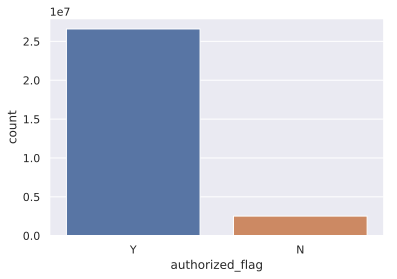

In [5]:
# authorized_flag
sns.countplot(x='authorized_flag', data=hist_trans)
plt.show()

In [ ]:
# card_id has 325540 unique values

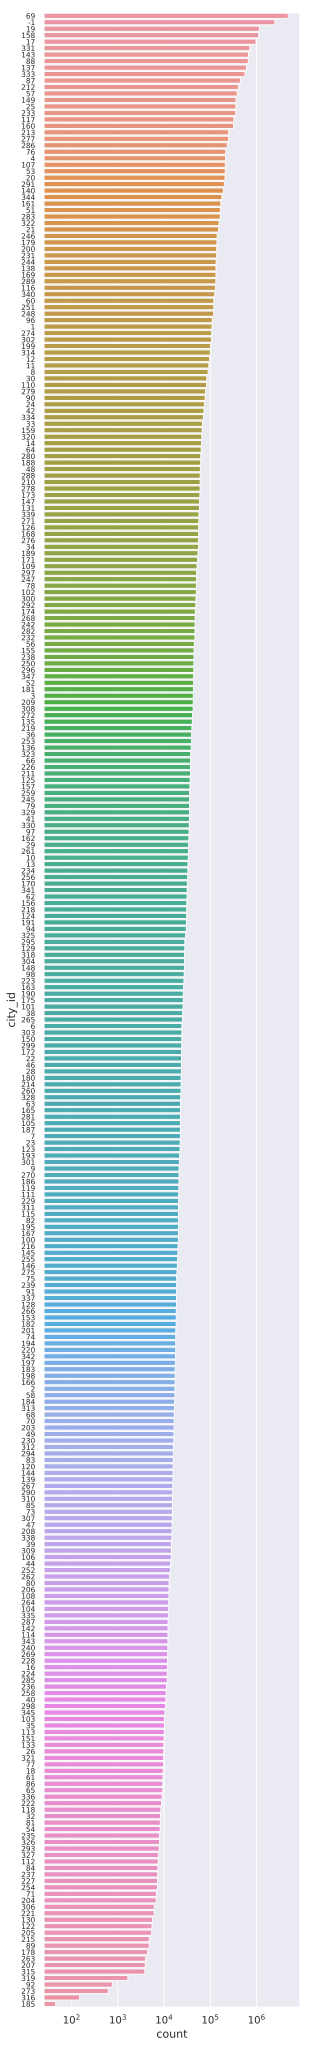

In [15]:
# city_id
plt.figure(figsize=(5, 40))
sns.countplot(y='city_id', data=hist_trans,
              order=hist_trans['city_id'].value_counts().index)
plt.yticks(fontsize=8)
plt.gca().set(xscale='log')
plt.show()

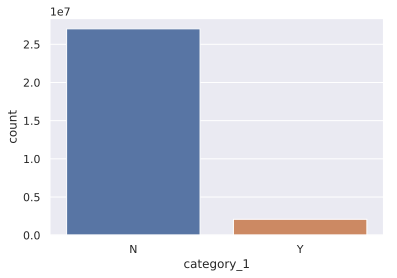

In [16]:
# category_1
sns.countplot(x='category_1', data=hist_trans)
plt.show()

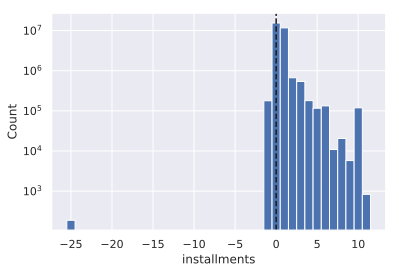

In [17]:
# installments
plt.hist(hist_trans['installments'], bins=np.arange(-25.5, 12.5, 1.0))
plt.axvline(x=0, color='k', linestyle='--')
plt.ylabel('Count')
plt.xlabel('installments')
plt.yscale('log', nonposy='clip')
plt.show()

In [ ]:
# TODO: what does it mean to have negative or zero number of installments?
# maybe just treat those as nans?  Or add indicator col?

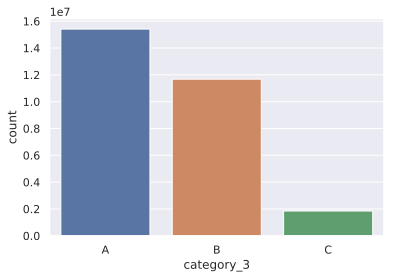

In [18]:
# category_3
sns.countplot(x='category_3', data=hist_trans)
plt.show()

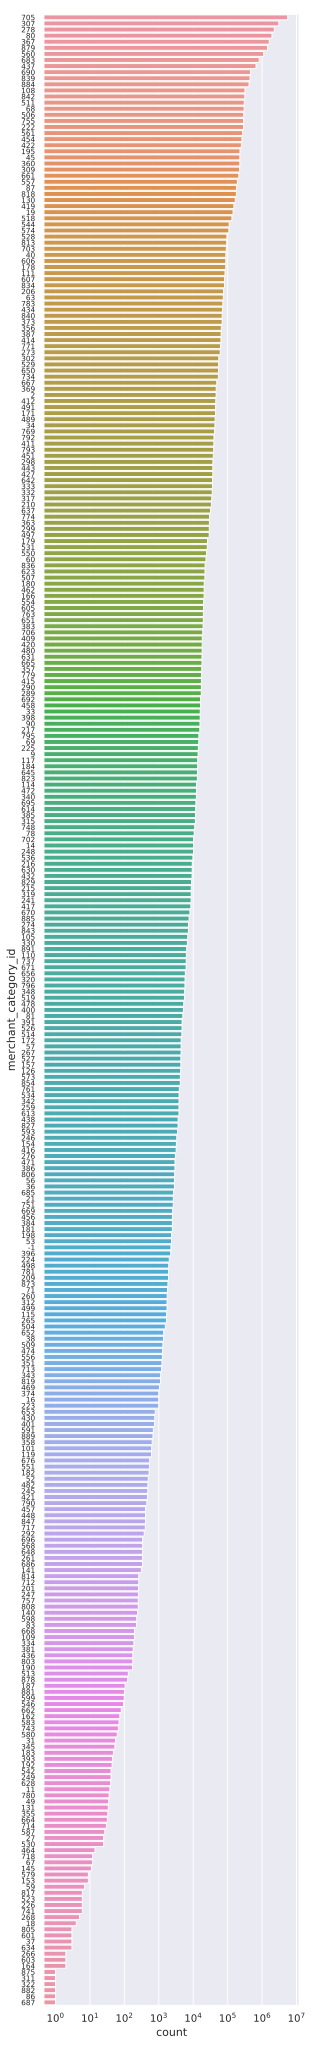

In [19]:
# merchant_category_id
plt.figure(figsize=(5, 40))
sns.countplot(y='merchant_category_id', data=hist_trans,
              order=hist_trans['merchant_category_id'].value_counts().index)
plt.yticks(fontsize=8)
plt.gca().set(xscale='log')
plt.show()

In [ ]:
# merchant_id has 326312 unique values

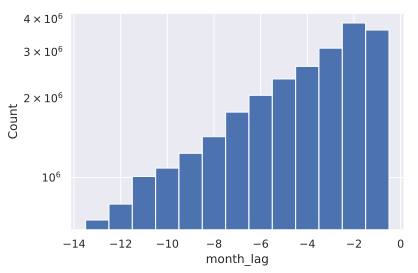

In [20]:
plt.hist(hist_trans['month_lag'], bins=np.arange(-13.5, 0.5, 1.0))
plt.ylabel('Count')
plt.xlabel('month_lag')
plt.yscale('log')
plt.show()

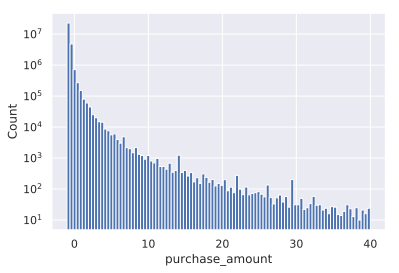

In [21]:
# purchase_amount
plt.hist(hist_trans['purchase_amount'], bins=np.linspace(-1, 40, 100))
plt.ylabel('Count')
plt.xlabel('purchase_amount')
plt.yscale('log')
plt.show()

# NOTE that there are values up to 11269.667!
# some purchase amounts are <0 because the values are normalized

In [ ]:
# purchase_date goes from 2017-01-01 00:00:08  to  2018-02-28 23:59:51

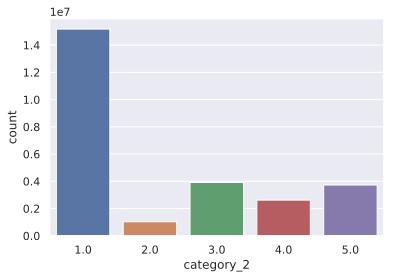

In [25]:
# category_2
sns.countplot(x='category_2', data=hist_trans)
plt.show()

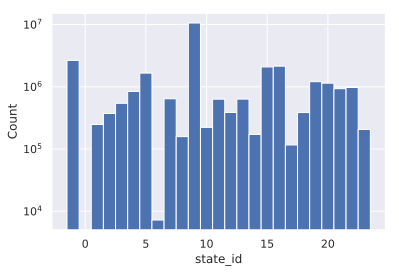

In [26]:
plt.hist(hist_trans['state_id'], bins=np.arange(-1.5, 24.5, 1.0))
plt.ylabel('Count')
plt.xlabel('state_id')
plt.yscale('log')
plt.show()

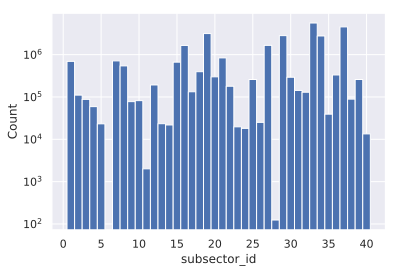

In [27]:
# subsector_id
plt.hist(hist_trans['subsector_id'], bins=np.arange(0.5, 41.5, 1.0))
plt.ylabel('Count')
plt.xlabel('subsector_id')
plt.yscale('log', nonposy='clip')
plt.show()

## Data Cleaning

In [ ]:
# TODO: cut off crazy high values of purchase_amount?